In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

/data1/WangCK/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 数据增强及划分数据集

In [2]:
# 设置随机种子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), interpolation=transforms.InterpolationMode.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


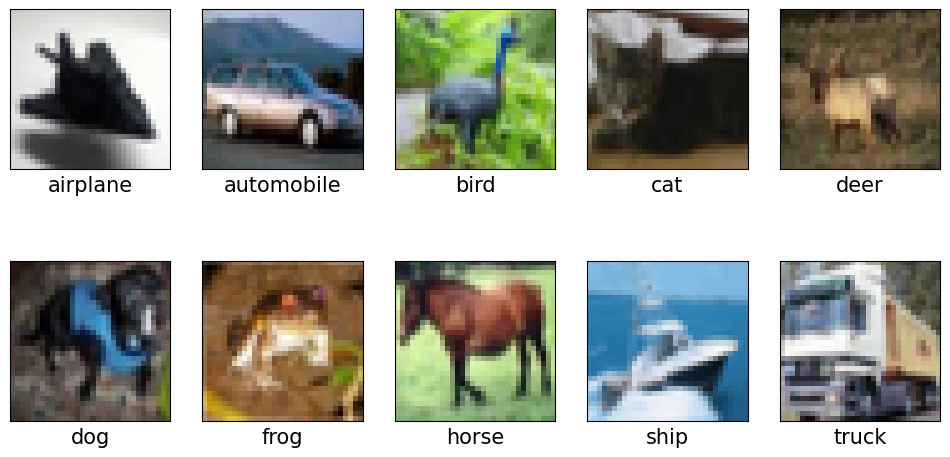

In [3]:
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## 定义CNN网络

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(p=0.25)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        # 全连接层
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_dense2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = F.relu(self.bn_conv2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout_conv(x)

        x = F.relu(self.bn_conv3(self.conv3(x)))
        x = F.relu(self.bn_conv4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout_conv(x)

        # 转为一维，匹配全连接层
        x = x.view(-1, 256 * 8 * 8)

        x = F.relu(self.bn_dense1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_dense2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)


Device: cuda:0


CNN(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_conv1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_conv4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (bn_dense1)

## Train

In [5]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_list, acc_list = [], []
loss_list_val, acc_list_val = [], []

for epoch in range(150):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = loss_fun(outputs, labels)
    loss.backward()
    optimizer.step()

    # 训练集数据
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_list.append(avg_loss)
  acc_list.append(avg_acc)

  # 验证集计算
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = loss_fun(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_list_val.append(avg_loss_val)
    acc_list_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

/data1/WangCK/anaconda3/envs/py39/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[epoch 1] loss: 0.01403 accuracy: 0.3479 val loss: 0.01199 val accuracy: 0.4495
[epoch 2] loss: 0.01155 accuracy: 0.4653 val loss: 0.00984 val accuracy: 0.5464
[epoch 3] loss: 0.01003 accuracy: 0.5433 val loss: 0.00818 val accuracy: 0.6254
[epoch 4] loss: 0.00879 accuracy: 0.6031 val loss: 0.00757 val accuracy: 0.6526
[epoch 5] loss: 0.00800 accuracy: 0.6425 val loss: 0.00669 val accuracy: 0.6948
[epoch 6] loss: 0.00741 accuracy: 0.6715 val loss: 0.00631 val accuracy: 0.7144
[epoch 7] loss: 0.00700 accuracy: 0.6894 val loss: 0.00590 val accuracy: 0.7446
[epoch 8] loss: 0.00664 accuracy: 0.7076 val loss: 0.00556 val accuracy: 0.7554
[epoch 9] loss: 0.00633 accuracy: 0.7232 val loss: 0.00536 val accuracy: 0.7609
[epoch 10] loss: 0.00605 accuracy: 0.7348 val loss: 0.00511 val accuracy: 0.7736
[epoch 11] loss: 0.00583 accuracy: 0.7461 val loss: 0.00470 val accuracy: 0.7940
[epoch 12] loss: 0.00561 accuracy: 0.7556 val loss: 0.00459 val accuracy: 0.7980
[epoch 13] loss: 0.00539 accuracy: 0.

## 绘制Loss与Accuracy曲线

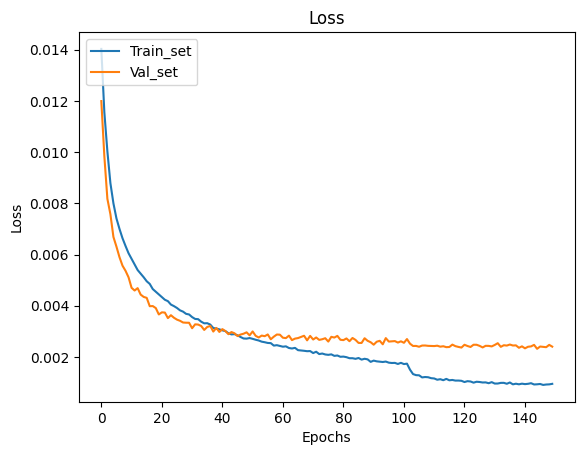

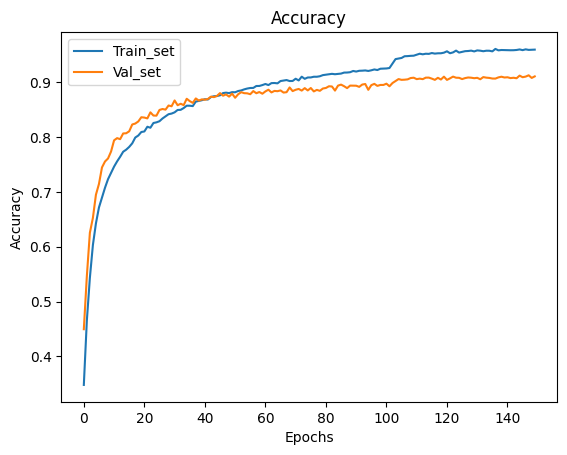

In [6]:
# 绘制损失曲线
legend = ['Train_set', 'Val_set']
plt.plot(loss_list)
plt.plot(loss_list_val)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

# 绘制准确率曲线
legend = ['Train_set', 'Val_set']
plt.plot(acc_list)
plt.plot(acc_list_val)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## 保存/加载Model

In [7]:
torch.save(net, 'net.pth')

In [8]:
net = torch.load('net.pth')

## Test

In [9]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 90.97 %
